# Steam Reviews Sentiment Analysis

## 1. Libraries/Imports


In [14]:
!pip install tensorflow transformers kagglehub seaborn nltk scikit-learn

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input, Bidirectional, Lambda

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel

# english dictionary and common stopwords
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Dataset Download and Exploration


In [16]:
# steam reviews dataset from kaggle
path = kagglehub.dataset_download("andrewmvd/steam-reviews")

dataset = pd.read_csv("/kaggle/input/steam-reviews/dataset.csv")

Using Colab cache for faster access to the 'steam-reviews' dataset.


Total reviews: 10000
Positive reviews: 5000
Negative reviews: 5000


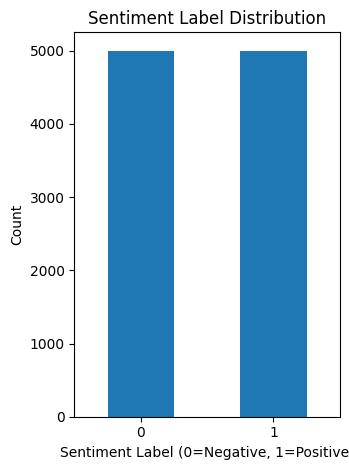

In [17]:
dataset = dataset[['review_text', 'review_score']].dropna()

dataset['sentiment_label'] = (dataset['review_score'] >= 1).astype(int)

negative_samples = dataset[dataset['sentiment_label'] == 0].sample(n=5000, random_state=42)
positive_samples = dataset[dataset['sentiment_label'] == 1].sample(n=5000, random_state=42)
sampled_dataset = pd.concat([negative_samples, positive_samples])


## 3. Text Preprocessing


In [18]:
# Basic preprocessing: lowercase, keep only letters and spaces
def basic_preprocessing(review_text):
    review_text = str(review_text).lower()
    filtered_chars = []
    for char in review_text:
        if char.isalpha() or char.isspace():
            filtered_chars.append(char)
    review_text = ''.join(filtered_chars)
    words = review_text.split()
    review_text = ' '.join(words)
    return review_text.strip()

# Advanced preprocessing: basic + remove stopwords, lemmatize, remove short words
def advanced_preprocessing(review_text):
    review_text = str(review_text).lower()
    filtered_chars = []
    for char in review_text:
        if char.isalpha() or char.isspace():
            filtered_chars.append(char)
    review_text = ''.join(filtered_chars)
    words = review_text.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = []
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in filtered_words:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    long_words = []
    for word in lemmatized_words:
        if len(word) > 1:
            long_words.append(word)
    return ' '.join(long_words)

# apply basic preprocessing to dataset as default
sampled_dataset['review_text_basic'] = sampled_dataset['review_text'].apply(basic_preprocessing)

## 4. Baseline Model: RNN/LSTM Neural Network


In [19]:
# apply advanced preprocessing
sampled_dataset['review_text_advanced'] = sampled_dataset['review_text'].apply(advanced_preprocessing)

# split into train and test sets
X_text_basic = sampled_dataset['review_text_basic'].values
X_text_advanced = sampled_dataset['review_text_advanced'].values
y_labels = sampled_dataset['sentiment_label'].values

X_train_basic, X_test_basic, y_train, y_test = train_test_split(X_text_basic, y_labels, test_size=0.2)
X_train_advanced, X_test_advanced, _, _ = train_test_split(X_text_advanced, y_labels, test_size=0.2)


# tokenize basic and advancedtext

max_features = 10000
max_len = 200

tokenizer_basic = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer_basic.fit_on_texts(X_train_basic)
X_train_seq_basic = tokenizer_basic.texts_to_sequences(X_train_basic)
X_test_seq_basic = tokenizer_basic.texts_to_sequences(X_test_basic)
X_train_padded_basic = pad_sequences(X_train_seq_basic, maxlen=max_len)
X_test_padded_basic = pad_sequences(X_test_seq_basic, maxlen=max_len)

tokenizer_advanced = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer_advanced.fit_on_texts(X_train_advanced)
X_train_seq_advanced = tokenizer_advanced.texts_to_sequences(X_train_advanced)
X_test_seq_advanced = tokenizer_advanced.texts_to_sequences(X_test_advanced)
X_train_padded_advanced = pad_sequences(X_train_seq_advanced, maxlen=max_len)
X_test_padded_advanced = pad_sequences(X_test_seq_advanced, maxlen=max_len)


In [20]:
# LTSM model architecture
def create_lstm_model(vocab_size, max_length):
    model = Sequential([Embedding(vocab_size, 128, input_length=max_length), Bidirectional(LSTM(64, return_sequences=True)), Bidirectional(LSTM(32)), Dense(32, activation='relu'), Dropout(0.3), Dense(1, activation='sigmoid')])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# LTSM basic and advanced models
lstm_model_basic = create_lstm_model(max_features, max_len)
lstm_model_advanced = create_lstm_model(max_features, max_len)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


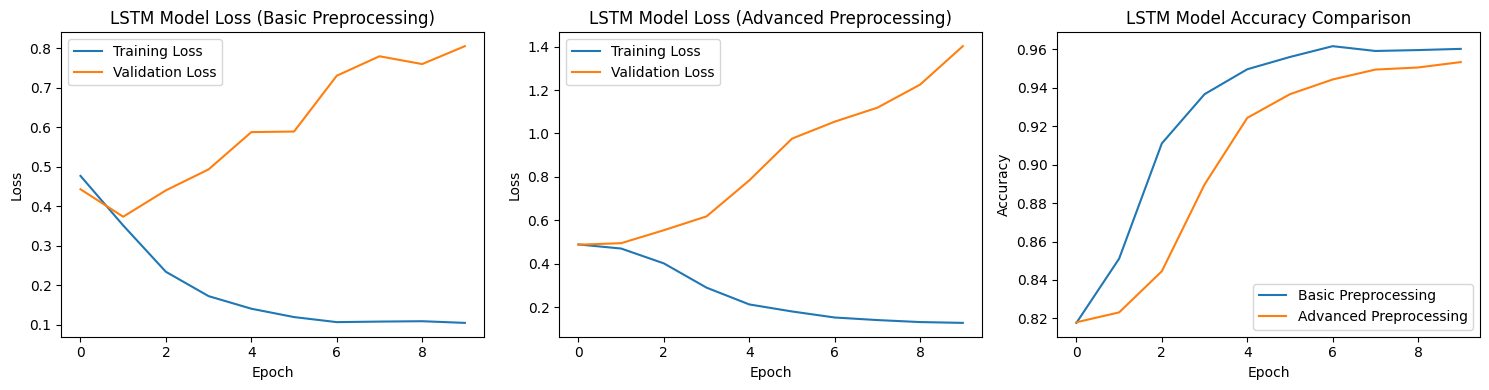

In [21]:
# train LSTM models
history_lstm_basic = lstm_model_basic.fit(X_train_padded_basic, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=0)
history_lstm_advanced = lstm_model_advanced.fit(X_train_padded_advanced, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=0)

# plot training results
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history_lstm_basic.history['loss'], label='Training Loss')
plt.plot(history_lstm_basic.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss (Basic Preprocessing)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_lstm_advanced.history['loss'], label='Training Loss')
plt.plot(history_lstm_advanced.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss (Advanced Preprocessing)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_lstm_basic.history['accuracy'], label='Basic Preprocessing')
plt.plot(history_lstm_advanced.history['accuracy'], label='Advanced Preprocessing')
plt.title('LSTM Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step


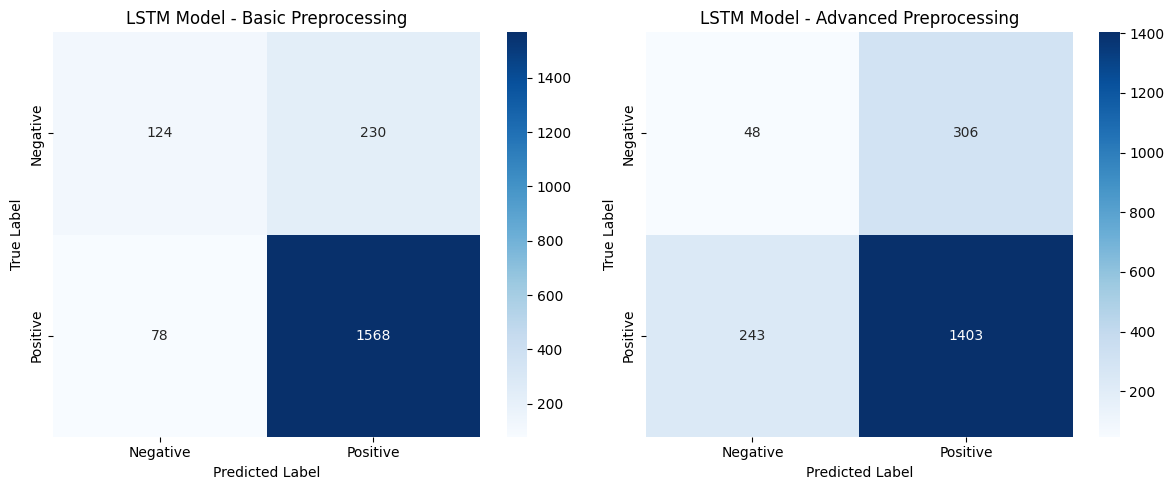

In [22]:
# prediction results
lstm_predictions_basic = lstm_model_basic.predict(X_test_padded_basic)
lstm_predictions_binary_basic = (lstm_predictions_basic > 0.5).astype(int).flatten()

lstm_predictions_advanced = lstm_model_advanced.predict(X_test_padded_advanced)
lstm_predictions_binary_advanced = (lstm_predictions_advanced > 0.5).astype(int).flatten()

# accuracy, precision, recall, and f1 score
lstm_accuracy_basic = accuracy_score(y_test, lstm_predictions_binary_basic)
lstm_precision_basic = precision_score(y_test, lstm_predictions_binary_basic)
lstm_recall_basic = recall_score(y_test, lstm_predictions_binary_basic)
lstm_f1_basic = f1_score(y_test, lstm_predictions_binary_basic)

lstm_accuracy_advanced = accuracy_score(y_test, lstm_predictions_binary_advanced)
lstm_precision_advanced = precision_score(y_test, lstm_predictions_binary_advanced)
lstm_recall_advanced = recall_score(y_test, lstm_predictions_binary_advanced)
lstm_f1_advanced = f1_score(y_test, lstm_predictions_binary_advanced)

# confusion matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_lstm_basic = confusion_matrix(y_test, lstm_predictions_binary_basic)
sns.heatmap(cm_lstm_basic, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('LSTM Model - Basic Preprocessing')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_lstm_advanced = confusion_matrix(y_test, lstm_predictions_binary_advanced)
sns.heatmap(cm_lstm_advanced, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('LSTM Model - Advanced Preprocessing')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 5. Improved Model: Transformer (BERT)


In [23]:
# split into train and test sets for BERT
X_bert_basic = sampled_dataset['review_text_basic'].values
X_bert_advanced = sampled_dataset['review_text_advanced'].values
y_bert = sampled_dataset['sentiment_label'].values

X_bert_train_basic, X_bert_test_basic, y_bert_train, y_bert_test = train_test_split(X_bert_basic, y_bert, test_size=0.2)
X_bert_train_advanced, X_bert_test_advanced, _, _ = train_test_split(X_bert_advanced, y_bert, test_size=0.2)

# BERT tokenizer
model_name = 'distilbert-base-uncased'
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
# tokenize text for BERT
def tokenize_bert_data(texts):
    return tokenizer_bert(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

train_encodings_basic = tokenize_bert_data(X_bert_train_basic)
test_encodings_basic = tokenize_bert_data(X_bert_test_basic)

train_encodings_advanced = tokenize_bert_data(X_bert_train_advanced)
test_encodings_advanced = tokenize_bert_data(X_bert_test_advanced)

base_bert_model_basic = TFAutoModel.from_pretrained(model_name, from_pt=True)
base_bert_model_advanced = TFAutoModel.from_pretrained(model_name, from_pt=True)

def create_bert_model(base_model):
    input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    def bert_call(inputs):
        ids, mask = inputs
        ids = tf.cast(ids, tf.int32)
        mask = tf.cast(mask, tf.int32)
        output = base_model(input_ids=ids, attention_mask=mask)
        return output.last_hidden_state[:, 0, :]

    pooled_output = Lambda(bert_call)([input_ids, attention_mask])
    dropout = Dropout(0.3)(pooled_output)
    dense = Dense(64, activation='relu')(dropout)
    dropout2 = Dropout(0.3)(dense)
    output = Dense(1, activation='sigmoid')(dropout2)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

bert_model_basic = create_bert_model(base_bert_model_basic)
bert_model_advanced = create_bert_model(base_bert_model_advanced)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

In [ ]:
val_size = int(0.2 * len(X_bert_train_basic))

train_dataset_basic = tf.data.Dataset.from_tensor_slices(((train_encodings_basic['input_ids'][val_size:], train_encodings_basic['attention_mask'][val_size:]), y_bert_train[val_size:])).batch(16)
val_dataset_basic = tf.data.Dataset.from_tensor_slices(((train_encodings_basic['input_ids'][:val_size], train_encodings_basic['attention_mask'][:val_size]), y_bert_train[:val_size])).batch(16)
train_dataset_advanced = tf.data.Dataset.from_tensor_slices(((train_encodings_advanced['input_ids'][val_size:], train_encodings_advanced['attention_mask'][val_size:]), y_bert_train[val_size:])).batch(16)
val_dataset_advanced = tf.data.Dataset.from_tensor_slices(((train_encodings_advanced['input_ids'][:val_size], train_encodings_advanced['attention_mask'][:val_size]), y_bert_train[:val_size])).batch(16)

history_bert_basic = bert_model_basic.fit(train_dataset_basic, validation_data=val_dataset_basic, epochs=3, verbose=0)
history_bert_advanced = bert_model_advanced.fit(train_dataset_advanced, validation_data=val_dataset_advanced, epochs=3, verbose=0)

# training results
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(history_bert_basic.history['loss'], label='Training Loss')
plt.plot(history_bert_basic.history['val_loss'], label='Validation Loss')
plt.title('BERT Model Loss (Basic Preprocessing)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_bert_advanced.history['loss'], label='Training Loss')
plt.plot(history_bert_advanced.history['val_loss'], label='Validation Loss')
plt.title('BERT Model Loss (Advanced Preprocessing)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_bert_basic.history['accuracy'], label='Basic Preprocessing')
plt.plot(history_bert_advanced.history['accuracy'], label='Advanced Preprocessing')
plt.title('BERT Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# prediction results
bert_predictions_basic = bert_model_basic.predict([test_encodings_basic['input_ids'], test_encodings_basic['attention_mask']])
bert_predictions_binary_basic = (bert_predictions_basic > 0.5).astype(int).flatten()

bert_predictions_advanced = bert_model_advanced.predict([test_encodings_advanced['input_ids'], test_encodings_advanced['attention_mask']])
bert_predictions_binary_advanced = (bert_predictions_advanced > 0.5).astype(int).flatten()

# accuracy, precision, recall, and f1 score
bert_accuracy_basic = accuracy_score(y_bert_test, bert_predictions_binary_basic)
bert_precision_basic = precision_score(y_bert_test, bert_predictions_binary_basic)
bert_recall_basic = recall_score(y_bert_test, bert_predictions_binary_basic)
bert_f1_basic = f1_score(y_bert_test, bert_predictions_binary_basic)

bert_accuracy_advanced = accuracy_score(y_bert_test, bert_predictions_binary_advanced)
bert_precision_advanced = precision_score(y_bert_test, bert_predictions_binary_advanced)
bert_recall_advanced = recall_score(y_bert_test, bert_predictions_binary_advanced)
bert_f1_advanced = f1_score(y_bert_test, bert_predictions_binary_advanced)

# confusion matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_bert_basic = confusion_matrix(y_bert_test, bert_predictions_binary_basic)
sns.heatmap(cm_bert_basic, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('BERT Model - Basic Preprocessing')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_bert_advanced = confusion_matrix(y_bert_test, bert_predictions_binary_advanced)
sns.heatmap(cm_bert_advanced, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('BERT Model - Advanced Preprocessing')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 6. Model Comparison and Analysis


In [ ]:
# comparison data between different scores and models
models = ['LSTM (Basic)', 'LSTM (Advanced)', 'BERT (Basic)', 'BERT (Advanced)']
accuracies = [lstm_accuracy_basic, lstm_accuracy_advanced, bert_accuracy_basic, bert_accuracy_advanced]
precisions = [lstm_precision_basic, lstm_precision_advanced, bert_precision_basic, bert_precision_advanced]
recalls = [lstm_recall_basic, lstm_recall_advanced, bert_recall_basic, bert_recall_advanced]
f1_scores = [lstm_f1_basic, lstm_f1_advanced, bert_f1_basic, bert_f1_advanced]

# plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2
ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', alpha=0.8)
ax.bar(x - 0.5*width, precisions, width, label='Precision', alpha=0.8)
ax.bar(x + 0.5*width, recalls, width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, f1_scores, width, label='F1-Score', alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("FINAL MODEL PERFORMANCE RESULTS")
print("=" * 50)
print(f"\nLSTM Basic Preprocessing:")
print(f"  Accuracy:  {lstm_accuracy_basic:.4f}")
print(f"  Precision: {lstm_precision_basic:.4f}")
print(f"  Recall:    {lstm_recall_basic:.4f}")
print(f"  F1-Score:  {lstm_f1_basic:.4f}")
print(f"\nLSTM Advanced Preprocessing:")
print(f"  Accuracy:  {lstm_accuracy_advanced:.4f}")
print(f"  Precision: {lstm_precision_advanced:.4f}")
print(f"  Recall:    {lstm_recall_advanced:.4f}")
print(f"  F1-Score:  {lstm_f1_advanced:.4f}")
print(f"\nBERT Basic Preprocessing:")
print(f"  Accuracy:  {bert_accuracy_basic:.4f}")
print(f"  Precision: {bert_precision_basic:.4f}")
print(f"  Recall:    {bert_recall_basic:.4f}")
print(f"  F1-Score:  {bert_f1_basic:.4f}")
print(f"\nBERT Advanced Preprocessing:")
print(f"  Accuracy:  {bert_accuracy_advanced:.4f}")
print(f"  Precision: {bert_precision_advanced:.4f}")
print(f"  Recall:    {bert_recall_advanced:.4f}")
print(f"  F1-Score:  {bert_f1_advanced:.4f}")
print("\n" + "=" * 50)
